# [종목 간 선후행 관계 파악 가정](https://gils-lab.tistory.com/13?category=504500)
- 종목 간 선후행 관계가 존재하는지를 확인하고자 한다.
- 가령, 한 종목의 주가가 올라가면 다른 종목의 주가가 뒤따라서 올라가는 그러한 관계를 확인하고자 한다.

## 실험 대상
- 종목: 2016년 9월 1일부터 2021년 8월31일까지 주가 데이터가 있는 코스피 종목 
- 구간: 2016년 9월 1일 ~ 2021년 8월 31일 (전 구간) / 2020년 9월 1일 ~ 2021년 8월 31일 (최신 구간)

## 실험 이해를 위한 배경 지식
- 시계열의 정상성(stationarity)이란 시계열의 활률적인 성질들이 시간의 흐름에 따라 변하지 않는다는 것을 의미한다.
    - 정상 시계열인지 판단하는 통계적인 방법으로는 adfuller 검정이 있다.
- 비정상 시계열일지라도 차분이나 변환을 통해 정상 시계열로 바꿀 수 있다.
- 시계열 간 인과관계를 분석하는데 있어 자주 사용되는 방법은 그랜저 인과관계(Granger Causality)분석이 있다. 
    - 시계열 A와 B가 있을 때, B를 예측하는데 과거의 B값만 사용하는 것보다 과거의 A값도 같이 사용했을 때 예측 정확도가 통계적으로 유의하게 올라간다면, A가 B를 그래저 인과한다고 부른다. 쉽게 생각해서 A가 B에 대해 선행하는 시계열이라고 볼 수 있다.
    - 그랜저 인과관계 분석에 사용되는 두 시계열은 정상 시계열이여야 한다.

## 실험방법
1. 종목별 종가의 1차 차분을 계산한다.
2. 1차 차분에 대해 adufller 검정을 수행하여, 정상 시계열이라고 파단되는 종목의 1차 차분만 남긴다. 
3. 정상 시계열이라고 판단된 종목 집합으로부터 선택 가능한 모든 순서 쌍(A,B)를 선택하여 lag를 1부터 10까지 바꿔가면서 그래저 인과관계 분석을 실시한다. 
4. 모든 순서 쌍에 대해 p-value가 가장 작은 lag와 그 때의 p-value를 확인한다. 만약 p-value가 0.01 이상이라면 두 종목은 관계가 없다고 간주하고, 0.01 미만이라면 A가 B에 대해 lag만큼 선행한다고 간주한다. 

## 실험 결과 정리 및 응용 방법
- 종목 간 선후 관계들을 시각적으로 이해할 수 있도록 정리한다.
- 피어 그룹별 대장주가 무엇인지 식별한다.
- 종목 간 선후 관계를 바탕으로 주가를 예측하는 추가 실험을 진행한다.

# [코드](https://gils-lab.tistory.com/19)

In [13]:
import os
import pandas as pd
import warnings
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests as GCT
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'D2Coding'


from tqdm import tqdm
import FinanceDataReader as fdr 
fdr.__version__

'0.9.50'

## Data

In [2]:
save_path = '../../data/meta/stock_corps.csv'
df_dtype = {
    'stock_code': 'object'
}

df_corps = pd.read_csv(save_path, dtype=df_dtype)

print(f'{df_corps.shape} / {df_corps.isnull().sum().sum()}')
df_corps.head()

(2481, 11) / 560


,stock_code,corp_name,corp_cls_nm,industry_krx_nm,industry_krx_desc,industry_wics_ls_nm,industry_wics_ls_cd,industry_wics_ms_nm,industry_wics_ms_cd,industry_wics_ss_nm,industry_wics_ss_cd
0,950130,엑세스바이오,kosdaq,의료용품 및 기타 의약 관련제품 제조업,"말라리아 진단키트(RDT), HIV 진단키트(RDT)",NaN,NaN,NaN,NaN,NaN,NaN
1,900070,글로벌에스엠,kosdaq,기타 금융업,"자회사 제품 : IT기기용 정밀 화스너부품(스크류, 샤프트, 스프링)",NaN,NaN,NaN,NaN,NaN,NaN
2,900290,GRT,kosdaq,기타 금융업,"광학필름, 포장필름",NaN,NaN,NaN,NaN,NaN,NaN
3,094800,맵스리얼티1,kospi,신탁업 및 집합투자업,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,900260,로스웰,kosdaq,기타 금융업,"CAN Control Gateway, CAN기능모듈, BCM 차체제어모듈",NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_kospi = df_corps[df_corps['corp_cls_nm'] == 'kospi'][['stock_code', 'corp_name']]

df_kospi.head()

,stock_code,corp_name
3,094800,맵스리얼티1
7,088980,맥쿼리인프라
14,105840,우진
19,000490,대동
21,001820,삼화콘덴서공업


In [4]:
all_df = pd.DataFrame()

for kospi_value in tqdm(df_kospi.values):
    _df = fdr.DataReader(kospi_value[0], '2016-09-01', '2021-08-31')[['Close']]
    _df = _df.rename(columns={'Close':kospi_value[1]})
    all_df = pd.concat([all_df, _df], axis = 1) # 열 추가

print(f'{all_df.shape} / {all_df.isnull().sum().sum()}')
all_df.head()

  0%|          | 0/834 [00:00<?, ?it/s]

100%|██████████| 834/834 [01:58<00:00,  7.03it/s]

(1229, 834) / 85784


,맵스리얼티1,맥쿼리인프라,우진,대동,삼화콘덴서공업,유니온,우진플라임,페이퍼코리아,넥센,서연이화,...,영흥,태경산업,신영와코루,대우건설,수산인더스트리,하나제약,케이티스카이라이프,세원이앤씨,티웨이항공,HD현대인프라코어
Date,,,,,,,,,,,,,,,,,,,,,
2016-09-01,4280,8760,6930,7320,10800,3995,3195,13229,8130,16450,...,1920,4985,14900,6060,NaN,NaN,16050,1653,NaN,6957
2016-09-02,4260,8800,6980,7350,10650,4005,3360,12983,8100,16400,...,1900,4990,15100,6040,NaN,NaN,15950,1668,NaN,6965
2016-09-05,4270,8820,6920,7330,10600,4040,3700,13341,8140,16550,...,1920,4980,15400,6140,NaN,NaN,16300,1673,NaN,7261
2016-09-06,4280,8780,6880,7340,10500,4040,3890,12983,8230,16200,...,1910,4990,15150,6110,NaN,NaN,16200,1675,NaN,7185
2016-09-07,4275,8760,6750,7460,10250,4040,3775,12774,8150,15800,...,1910,5000,15050,6090,NaN,NaN,16200,1708,NaN,7482


In [5]:
for period in [['2016-09-01', '2021-08-31'], ['2020-09-01', '2021-08-31']]:
    start, end = period
    period_df = all_df.loc[start:end]
    period_df.dropna(axis = 1, inplace = True) # 결측이 하나라도 있는 종목은 삭제

    # 1차 차분 수행
    period_df = period_df.diff().dropna()
    
    # adfuller 테스트 수행해서 정상성을 띈다고 판단된 컬럼만 사용
    ADF_passed_columns = []
    for col in period_df.columns:
        if adfuller(period_df[col])[1] < 0.05:
            ADF_passed_columns.append(col)
            
    result = []
    temp = [] # 계산한 컬럼 튜플을 저장해놓는 곳
    i = 0
    n = len(ADF_passed_columns) * len(ADF_passed_columns)
    for col1 in tqdm(ADF_passed_columns):
        for col2 in ADF_passed_columns:
            i += 1
            if (col1 == col2) or ((col1, col2) in temp) or ((col1, col2) in temp):
                pass
            else:
                # 선택 가능한 모든 컬럼 조합 선택
                temp.append((col1, col2))
                try:
                    GCT_result = GCT(period_df[[col1, col2]], maxlag = 11, verbose = False)
                    min_pvalue = 1
                    for lag in range(1, 11):
                        pvalue = GCT_result[lag][0]['ssr_chi2test'][1]
                        if pvalue < min_pvalue:
                            min_pvalue = pvalue
                            min_lag = lag

                    if min_pvalue < 0.01:
                        result.append([col2, col1, min_lag, min_pvalue])
                except:
                    pass
                
                
    result = pd.DataFrame(result, columns = ["선행종목", "후행종목", "lag", "pvalue"])
    result.to_csv("{}-{}_선후행관계분석결과.csv".format(start, end))

100%|██████████| 722/722 [6:04:58<00:00, 30.33s/it]  


ValueError: Invalid input, x is constant

In [20]:
result.sort_values(by=['lag', 'pvalue'], ascending=[False,True]).head()

,선행종목,후행종목,lag,pvalue
39880,대동전자,퍼시스,10,4.608509e-80
58663,신흥,KPX홀딩스,10,4.231803e-67
51819,동방,제주은행,10,2.629066e-61
74142,가온전선,대한전선,10,3.025197e-57
48786,한전산업,한세엠케이,10,3.356261e-53


<Axes: xlabel='Date'>

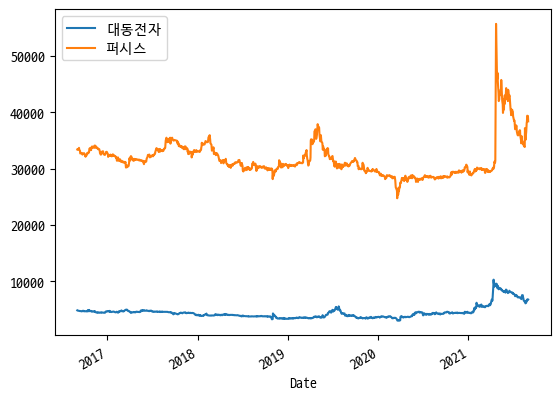

In [21]:
all_df[['대동전자', '퍼시스']].plot()

<Axes: xlabel='Date'>

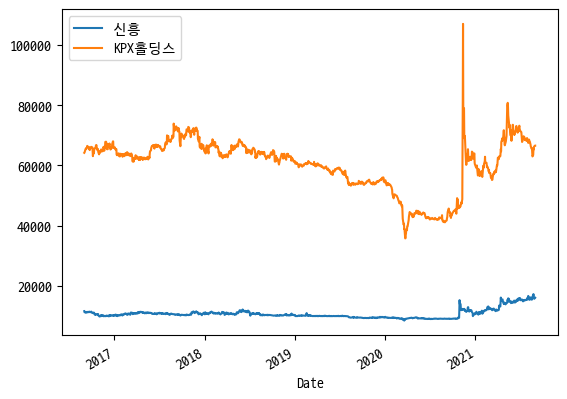

In [22]:
all_df[['신흥', 'KPX홀딩스']].plot()

In [23]:
result.sort_values(by=['lag', 'pvalue'], ascending=[True,False]).head()

,선행종목,후행종목,lag,pvalue
23319,보해양조,에스원,1,0.009999
5213,금호건설,일성건설,1,0.009999
8782,세아베스틸지주,GS글로벌,1,0.009998
20618,LG헬로비전,진원생명과학,1,0.009996
77015,현대코퍼레이션,AJ네트웍스,1,0.009996


<Axes: xlabel='Date'>

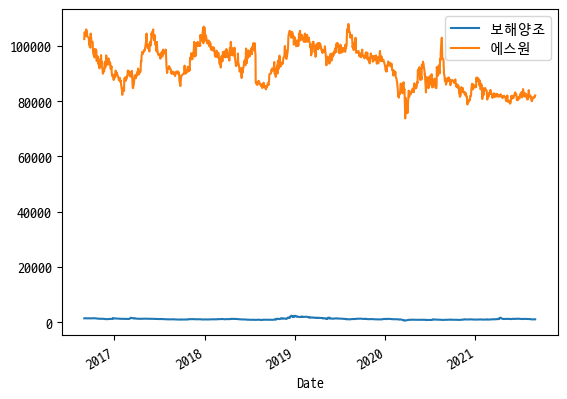

In [24]:
all_df[['보해양조', '에스원']].plot()

<Axes: xlabel='Date'>

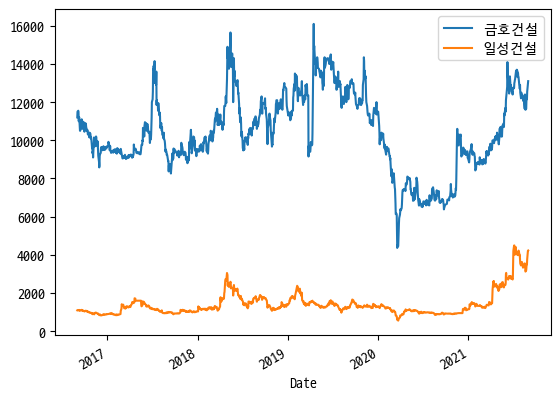

In [25]:
all_df[['금호건설', '일성건설']].plot()